In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
import torchvision.transforms as tf
from tqdm import tqdm
from predict import *
from HIST2ST import *
from dataset import ViT_HER2ST, ViT_SKIN
from scipy.stats import pearsonr,spearmanr
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

[easydl] tensorflow not available!


# Data Loading

In [2]:
name=[*[f'A{i}' for i in range(2,7)],*[f'B{i}' for i in range(1,7)],
      *[f'C{i}' for i in range(1,7)],*[f'D{i}' for i in range(1,7)],
      *[f'E{i}' for i in range(1,4)],*[f'F{i}' for i in range(1,4)],*[f'G{i}' for i in range(1,4)]]
patients = ['P2', 'P5', 'P9', 'P10']
reps = ['rep1', 'rep2', 'rep3']
skinname = []
for i in patients:
    for j in reps:
        skinname.append(i+'_ST_'+j)
device='cuda'
tag='5-7-2-8-4-16-32'
k,p,d1,d2,d3,h,c=map(lambda x:int(x),tag.split('-'))
dropout=0.2
random.seed(12000)
np.random.seed(12000)
torch.manual_seed(12000)
torch.cuda.manual_seed(12000)
torch.cuda.manual_seed_all(12000)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
fold=5
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785
trainset = pk_load(fold,'train',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
train_loader = DataLoader(trainset, batch_size=1, num_workers=0, shuffle=True)

['B1']
Loading imgs...
Loading metadata...


# Hist2ST training

In [4]:
model=Hist2ST(
    depth1=d1, depth2=d2,depth3=d3,n_genes=genes,
    kernel_size=k, patch_size=p,
    heads=h, channel=c, dropout=0.2,
    zinb=0.25, nb=False,
    bake=5, lamb=0.5, 
)

In [6]:
logger=None
trainer = pl.Trainer(
    gpus=[0], max_epochs=350,
    logger=logger,
)
trainer.fit(model, train_loader)

import os
if not os.path.isdir("./model/"):
    os.mkdir("./model/")

torch.save(model.state_dict(),f"./model/{fold}-Hist2ST.ckpt")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Conv2d     | 4.7 K 
1 | x_embed         | Embedding  | 65.5 K
2 | y_embed         | Embedding  | 65.5 K
3 | vit             | ViT        | 71.4 M
4 | mean            | Sequential | 804 K 
5 | disp            | Sequential | 804 K 
6 | pi              | Sequential | 804 K 
7 | coef            | Sequential | 1.1 M 
8 | gene_head       | Sequential | 806 K 
-----------------------------------------------
75.8 M    Trainable params
0         Non-trainable params
75.8 M    Total params
303.159   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

# Hist2ST Prediction

In [6]:
fold=5
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

In [7]:
testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
label=testset.label[testset.names[0]]
genes=785
model=Hist2ST(
    depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
    kernel_size=k, patch_size=p,
    heads=h, channel=c, dropout=0.2,
    zinb=0.25, nb=False,
    bake=5, lamb=0.5, 
)
model.load_state_dict(torch.load(f'./model/{fold}-Hist2ST.ckpt'))
pred, gt = test(model, test_loader,'cuda')

['B1']
Loading imgs...
Loading metadata...


100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]


In [7]:
R=get_R(pred,gt)[0]
print('Pearson Correlation:',np.nanmean(R))
clus,ARI=cluster(pred,label)
print('ARI:',ARI)

Pearson Correlation: 0.2887870599966082
ARI: 0.431


... storing 'kmeans' as categorical


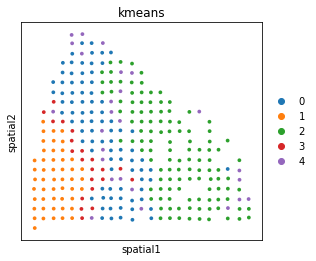

In [10]:
sc.pl.spatial(pred, img=None, color='kmeans', spot_size=112)